In [1]:
from Ornstein_Uhlenbeck import Ornstein_Uhlenbeck
from results_generator import *
from scipy.stats import norm
import backtrader as bt
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio as pf

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
stock_list = ['FEI           ', 'FEN']
obs = 252
cash = 100000000
commission = 0.004
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])

In [3]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'adjclose', 'volume')
    params = (('datetime', None),
              ('open', 0),
              ('high', 1),
              ('low', 2),
              ('close', 3),
              ('adjclose', 4),
              ('volume', 5))

In [4]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.obs = obs # number of observations used by the model
        self.n = 0 # number of days
        self.pos = 0 # initial position
        
        # model settings
        self.model = None
        self.a, self.b = 0, 1 # index of Sta and Stb
        self.s = 0 # used to update the EX and Var(X)
        self.dt = 1 / 252
        self.z = norm.ppf(0.99)
        
        # stop-loss
        self.sl = 1 # = 1 if stop-loss is added to the algo
        self.freeze = 0 # > 0 if stop-loss is triggered
        
        # logging the process
        self.date_list = []
        self.Xt_list = []
        self.lb_list = []
        self.ub_list = []

    def signal_generation(self):
        if self.model is None:
            return 0
        
        self.Xt = self.model.alpha * self.Sta[-1] - self.model.beta * self.Stb[-1]
        
        if self.freeze > 0:
            self.freeze -= 1
            return 0
        
        if self.pos == 1:
            if self.Xt >= self.EX + self.z * np.sqrt(self.VarX):
                return 0
            elif self.sl and self.Xt < self.Xs - self.z * np.sqrt(self.VarX):
                self.freeze += self.obs // 2
                print('Stoploss!')
                return 0
            else:
                return 1
        elif self.pos == -1:
            if self.Xt <= self.EX - self.z * np.sqrt(self.VarX):
                return 0
            elif self.sl and self.Xt > self.Xs + self.z * np.sqrt(self.VarX):
                self.freeze += self.obs // 2
                print('Stoploss!')
                return 0
            else:
                return -1
        else: # self.pos == 0
            if self.Xt > self.EX + self.z * np.sqrt(self.VarX):
                return -1
            elif self.Xt < self.EX - self.z * np.sqrt(self.VarX):
                return 1
            else:
                return 0
    
    def update_statistics(self):
        self.EX = self.model.mu + (self.X0 - self.model.mu) * np.exp(-self.model.theta * self.s * self.dt)
        self.VarX = self.model.sigma2 * (1 - np.exp(-2 * self.model.theta * self.s * self.dt)) / (2 * self.model.theta)
    
    def renew_model(self):
        model1 = Ornstein_Uhlenbeck(self.Sta, self.Stb)
        model2 = Ornstein_Uhlenbeck(self.Stb, self.Sta)
        if model1.l is None and model2.l is None:
            self.model = None
        elif model1.l is None and model2.l is not None:
            self.model = model2.l
            self.a, self.b = self.b, self.a
            self.Sta, self.Stb = self.Stb, self.Sta
        elif model1.l is not None and model2.l is None:
            self.model = model1.l
        else:
            if model1.l >= model2.l:
                self.model = model1
            else:
                self.model = model2
                self.a, self.b = self.b, self.a
                self.Sta, self.Stb = self.Stb, self.Sta
        if self.model is not None:
            self.X0 = self.model.alpha * self.Sta[-1] - self.model.beta * self.Stb[-1]
            self.s = 0
            self.update_statistics()
        
    def close_positions(self): # to close all existing positions
        for data in self.datas:
            self.close(data=data)
    
    def logging(self):
        self.date_list.append(self.data.datetime.date())
        self.Xt_list.append(self.Xt)
        self.lb_list.append(self.EX - self.z * np.sqrt(self.VarX))
        self.ub_list.append(self.EX + self.z * np.sqrt(self.VarX))

        if self.date_list[-1] == self.last_day:
            plt.figure(figsize=(10, 6))
            plt.plot(self.date_list, self.lb_list, label='Lower Bound')
            plt.plot(self.date_list, self.ub_list, label='Upper Bound')
            plt.plot(self.date_list, self.Xt_list, label=r'$X_t$')
            plt.legend()
    
    def start(self):
        self.last_day = self.data.datetime.date(-1)  # Get the last available date
        
    def next(self):
        self.Sta = np.array(self.datas[self.a].close.get(size=self.obs))
        self.Stb = np.array(self.datas[self.b].close.get(size=self.obs))
            
        self.n += 1
        if self.n == self.obs:
            self.renew_model()
            
        self.signal = self.signal_generation()
    
        if self.signal == 1:
            if self.pos == 0:
                if 0.8 * self.model.alpha / (self.model.beta * self.Stb[-1]) * self.Sta[-1] <= 1:
                    self.buy(data=self.datas[self.a], size=0.8 * cerebro.broker.get_value() * self.model.alpha / (self.model.beta * self.Stb[-1]))
                    self.sell(data=self.datas[self.b], size=0.8 * cerebro.broker.get_value() / self.Stb[-1])
                else:
                    self.buy(data=self.datas[self.a], size=cerebro.broker.get_value() / self.Sta[-1])
                    self.sell(data=self.datas[self.b], size=cerebro.broker.get_value() * self.model.beta / (self.model.alpha * self.Sta[-1]))
                self.Xs = self.Xt
                print("{}: Long pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                
        elif self.signal == -1:
            if self.pos == 0:
                if 0.8 * self.model.beta / (self.model.alpha * self.Sta[-1]) * self.Stb[-1] <= 1:
                    self.sell(data=self.datas[self.a], size=0.8 * cerebro.broker.get_value() / self.Sta[-1])
                    self.buy(data=self.datas[self.b], size=0.8 * cerebro.broker.get_value() * self.model.beta / (self.model.alpha * self.Sta[-1]))
                else:
                    self.sell(data=self.datas[self.a], size=cerebro.broker.get_value() * self.model.alpha / (self.model.beta * self.Stb[-1]))
                    self.buy(data=self.datas[self.b], size=cerebro.broker.get_value() / self.Stb[-1])
                self.Xs = self.Xt
                print("{}: Short pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                
        else: # self.signal == 0
            if self.pos != 0:
                self.close_positions()
                print("{}: Close pair when Xt = {}".format(self.data.datetime.date(), self.Xt))
                self.renew_model()
                
        self.pos = self.signal
        
        if self.n >= self.obs:
            self.logging()
            self.s += 1 # update the statistics for the next day
            self.update_statistics()
            
            if self.pos == 0 and self.s >= self.obs // 2:
                self.renew_model()

In [5]:
# backtest settings
cerebro = bt.Cerebro()

data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock], name=stock)
    cerebro.adddata(data_feed_dict[stock])

cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(cash)
cerebro.broker.setcommission(commission=commission)

2015-01-05: Long pair when Xt = 0.2172551239205468
Stoploss!
2015-12-04: Close pair when Xt = 0.18596576166893308
2016-12-05: Short pair when Xt = 0.22512524768467945
Stoploss!
2017-01-06: Close pair when Xt = 0.28183771396821866
2017-10-23: Long pair when Xt = 0.16817483086973928
2018-01-02: Close pair when Xt = 0.26635907410594895
2018-01-17: Long pair when Xt = 0.23654386130745897
Stoploss!
2018-03-15: Close pair when Xt = 0.18759811784955582
2019-03-18: Long pair when Xt = 0.250395143819382
Stoploss!
2019-10-15: Close pair when Xt = 0.15432559733225382
2020-04-17: Short pair when Xt = 0.13500147442854032
2020-05-22: Close pair when Xt = 0.050374644005544145
2020-11-19: Long pair when Xt = 0.01095491555903727
2022-01-11: Close pair when Xt = 0.11001729431541574
2022-07-12: Long pair when Xt = 0.3363546731297482
2022-08-23: Close pair when Xt = 0.5186232759426458
2022-08-26: Short pair when Xt = 0.3718274168514788
2022-09-27: Close pair when Xt = 0.20796358776967228
2023-01-12: Short

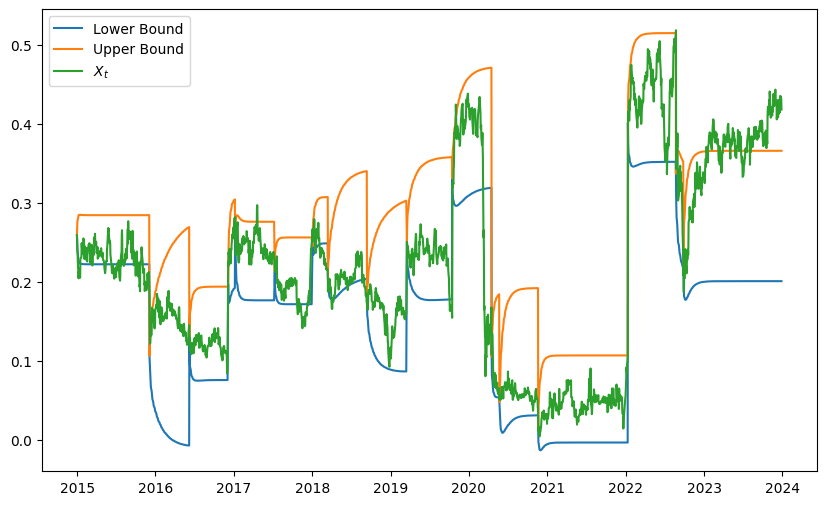

In [6]:
# Run the backtest
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

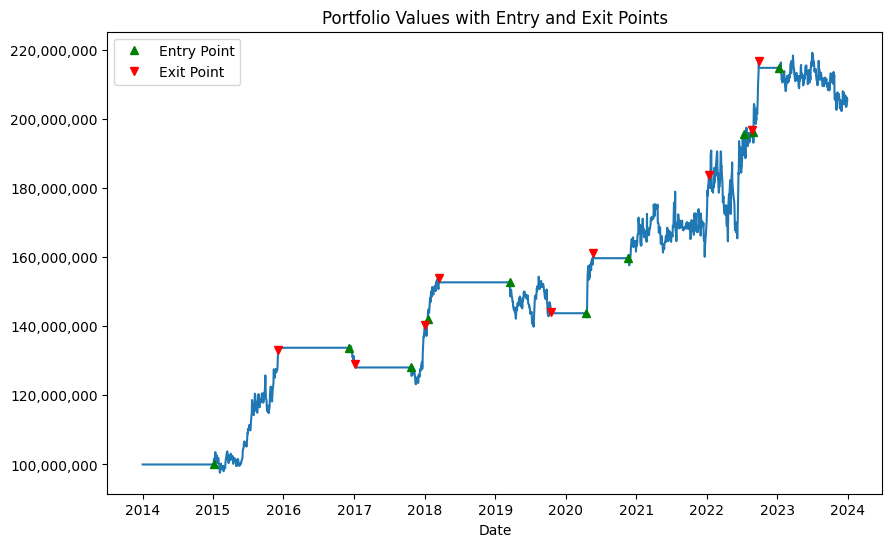

In [7]:
plot_portfolio_values(cash, returns, positions)

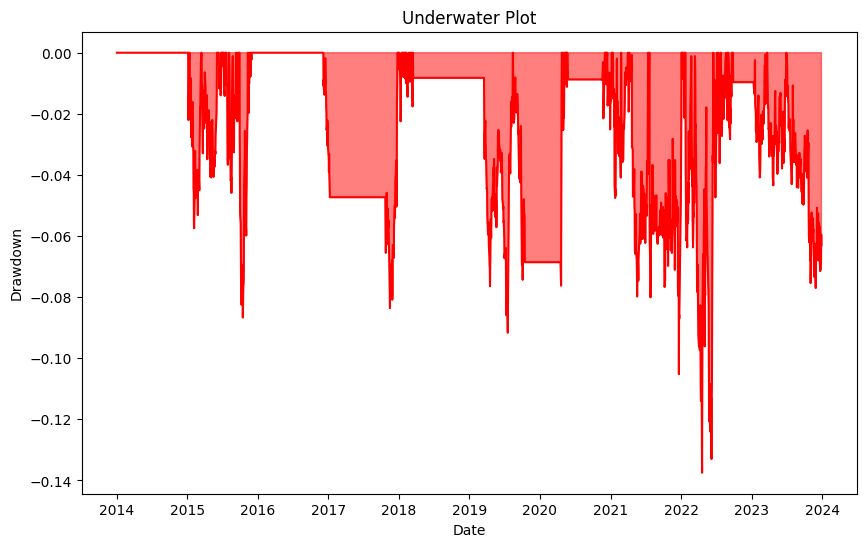

In [8]:
plot_underwater(returns)

                    In-sample Out-of-sample       All
Annual return            0.0%          8.3%      7.5%
Cumulative returns       0.0%        105.3%    105.3%
Annual volatility        0.0%         11.7%     11.1%
Sharpe ratio              NaN      0.742171  0.703961
Calmar ratio              NaN      0.606271  0.543337
Stability                 0.0       0.88944  0.917654
Max drawdown             0.0%        -13.7%    -13.7%
Omega ratio               NaN      1.192801  1.192801
Sortino ratio             NaN      1.157552  1.098053
Skew                      NaN      0.689735  0.741669
Kurtosis                  NaN      8.433789  9.715391
Tail ratio                NaN      1.149421  1.166867
Daily value at risk      0.0%         -1.4%     -1.4%


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:710: RuntimeWarning: invalid value encountered in divide
  np.divide(
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,13.75,2022-01-24,2022-04-20,2022-06-17,105
1,10.52,2021-07-21,2021-12-21,2022-01-04,120
2,9.17,2018-03-15,2019-07-19,2019-08-14,370
3,8.67,2015-09-29,2015-10-16,2015-11-11,32
4,8.36,2016-12-06,2017-11-16,2017-12-26,276


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1305: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1321: UserWarning: set_tic

Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,0.19%,-2.75%,2.39%
New Normal,0.03%,-4.85%,6.39%


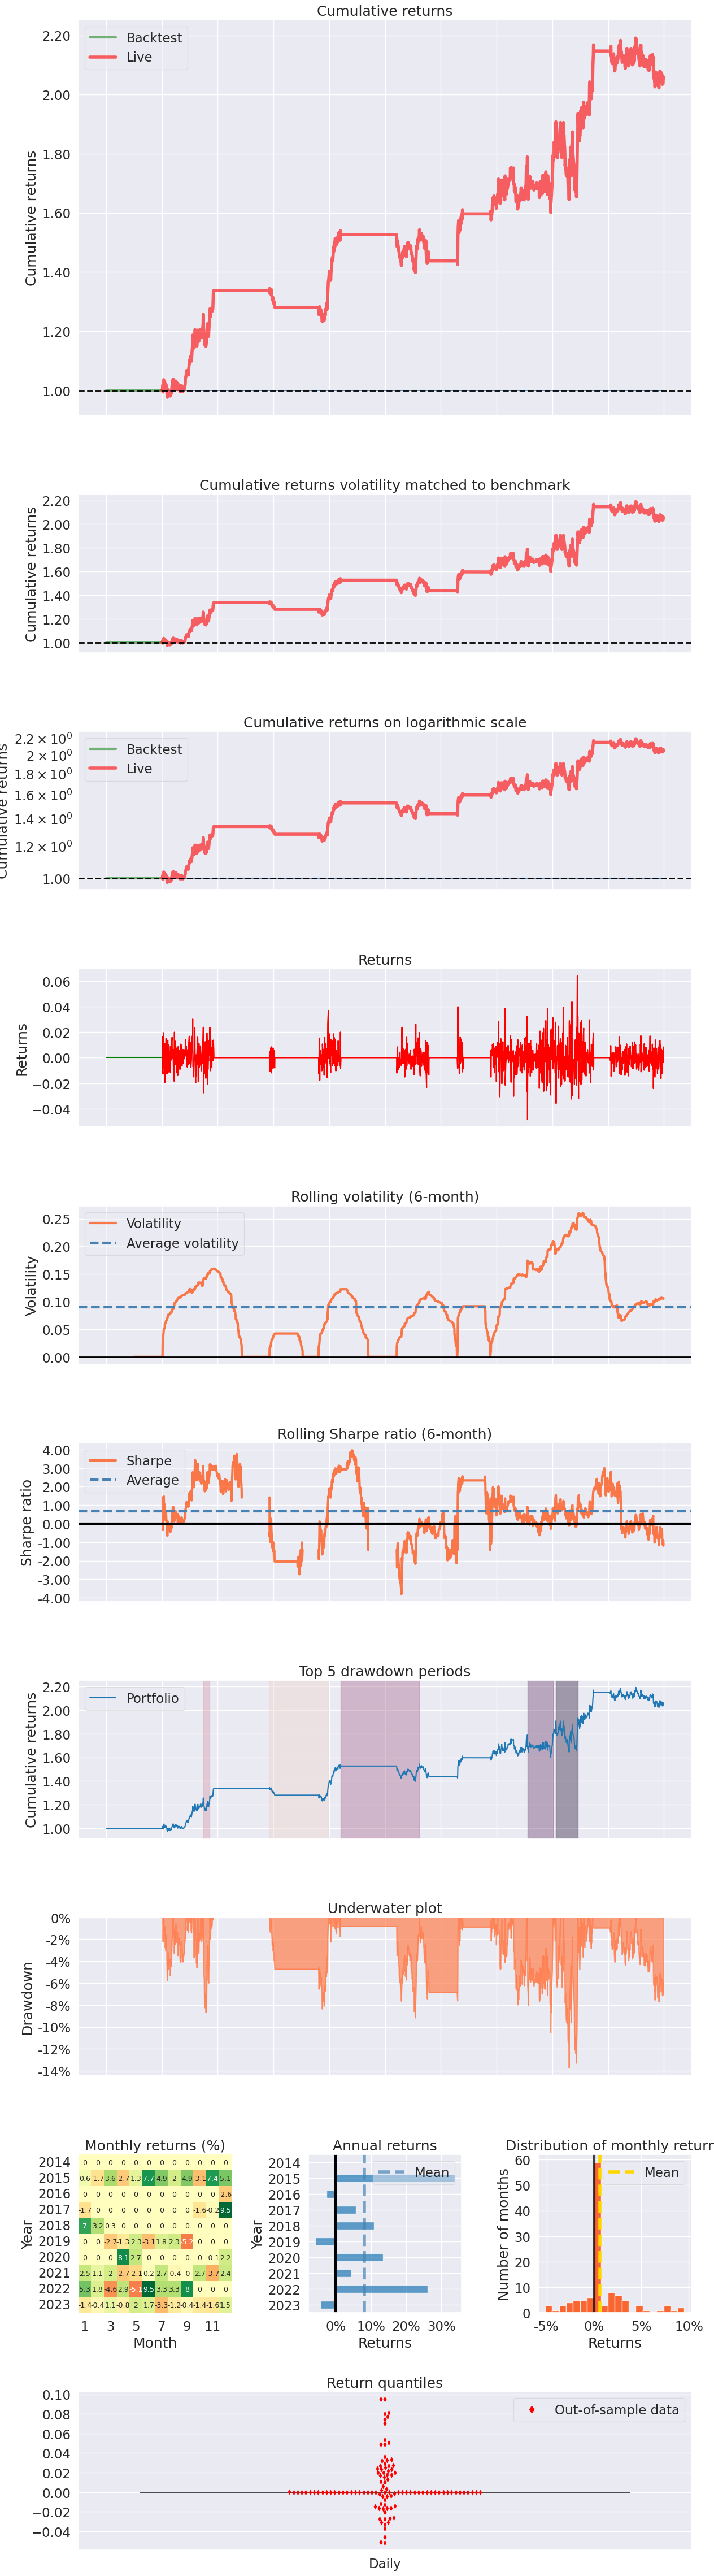

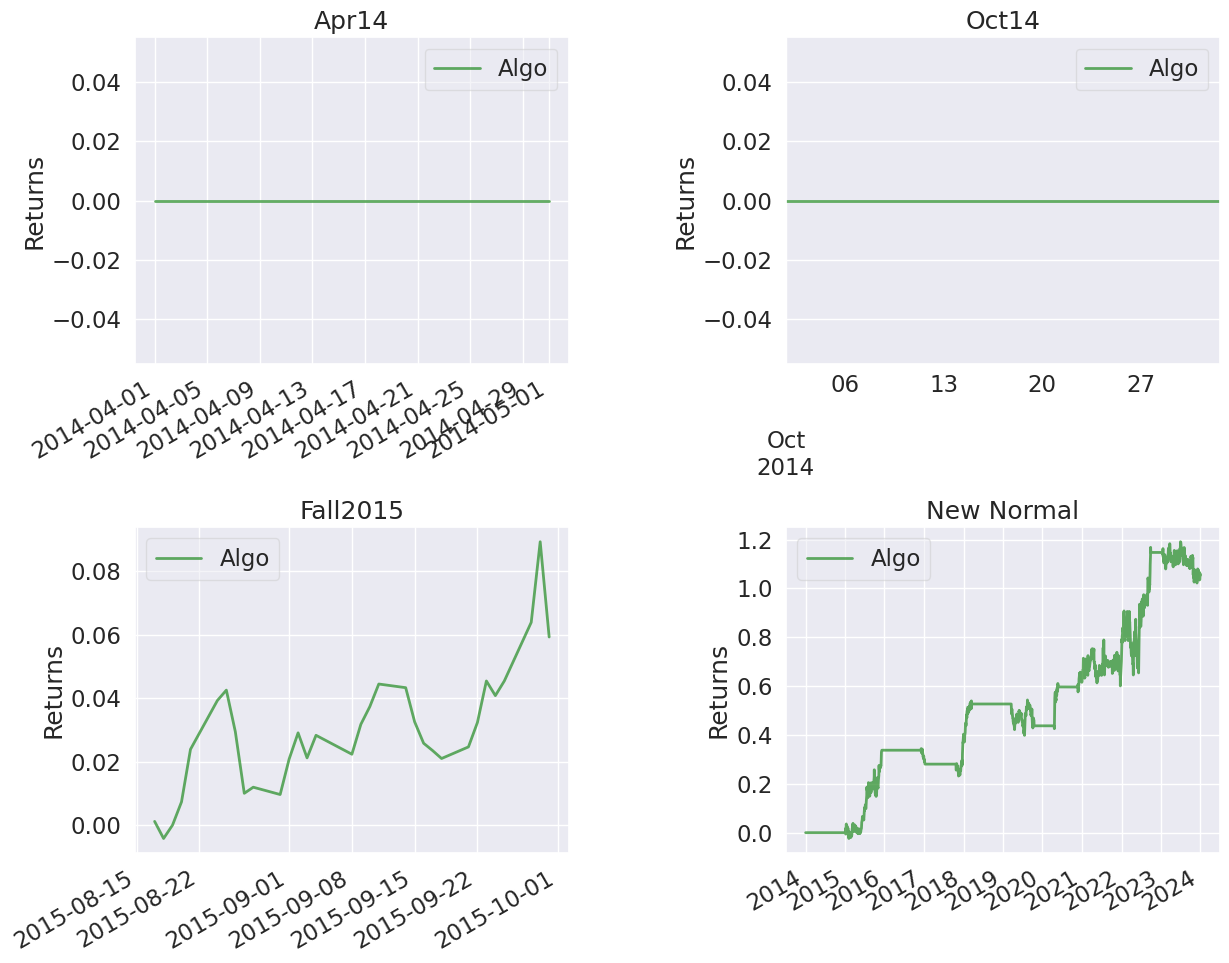

In [9]:
pf.create_full_tear_sheet(returns, live_start_date=stock_dict[stock_list[0]]['Close'].index[obs])
# pf.create_full_tear_sheet(returns, live_start_date=datetime.datetime(2020, 1, 1)) # custom start date